In [31]:
import pandas as pd
import spacy
import numpy as np
from os import listdir
import seaborn as sns
from scipy.sparse import  hstack
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer

# 1. data from CovidLit website and use the label provided there.

In [3]:
base_dir='LitCovid/'
all_file_names=listdir(base_dir)

In [4]:
def read_generate_labelled_files(base_dir,file_names):
    appended_data = []
    for file_name in file_names:
        data=pd.read_csv(base_dir+file_name,sep='\t')
        data['label']=file_name[:-4]
        appended_data.append(data)
    appended_data = pd.concat(appended_data,ignore_index=True).iloc[:,:4]
    return appended_data

In [5]:
#read all data and generate labelled data
data=read_generate_labelled_files(base_dir,all_file_names)

In [6]:
#convert float "pmid" to string
data['pmid'] = data['pmid'].astype(str).replace('\.0', '', regex=True)
data['title']=data['title'].values.astype('U')
data['journal']=data['journal'].values.astype('U')
data.dropna()

,pmid,title,journal,label
0,32315980,COVID-19 in a MS patient treated with ocrelizu...,Mult Scler Relat Disord,CaseReport
1,32315884,COVID-19 paranoia in a patient suffering from ...,Psychiatry Res,CaseReport
2,32315543,An Asymptomatic Patient Infected with Coronavi...,Am J Respir Crit Care Med,CaseReport
3,32315386,Atypical presentation of COVID-19 in a frail o...,Age Ageing,CaseReport
4,32315122,COVID-19 in a High-Risk Dual Heart and Kidney ...,Am J Transplant,CaseReport
...,...,...,...,...
6909,31986242,Medical Journals and the 2019-nCoV Outbreak.,N Engl J Med,general
6910,31980434,China coronavirus: what do we know so far?,BMJ,general
6911,31979013,Emerging Viruses without Borders: The Wuhan Co...,Viruses,general
6912,31969317,Coronavirus: UK screens direct flights from Wu...,BMJ,general


In [7]:
data.pmid.describe()

count         6914
unique        5439
top       32171952
freq             5
Name: pmid, dtype: object

 Since there are duplicate pmid, we drop duplicate and keep the first

In [8]:
data = data.drop_duplicates(subset='pmid', keep="first")

### 1.1 Using only title text feature: (BOW model)

In [40]:
text_train,text_test,y_train,y_test = train_test_split(data.title, data.label,train_size=0.8,shuffle=True)
plot_data=[["Method", "score", "step"]]

In [ ]:
tfidf_model=make_pipeline(CountVectorizer(ngram_range=(1,2)),
                        TfidfTransformer())
X_train=tfidf_model.fit_transform(text_train)
X_test=tfidf_model.transform(text_test)

In [41]:
lr=LogisticRegression(max_iter=5000).fit(X_train,y_train)
print('logistic regression - val score:')
train_score=lr.score(X_train,y_train)
print(train_score)
plot_data.append(['logistic regression',train_score,'train'])
print('logistic regression - test score:')
test_score=lr.score(X_test,y_test)
print(test_score)
plot_data.append(['logistic regression',test_score,'test'])

logistic regression - val score:
0.8205268935236004
logistic regression - test score:
0.6133704735376044


In [42]:
lsvc=LinearSVC(max_iter=5000).fit(X_train,y_train)
print('linear svc - val score:')
train_score=lsvc.score(X_train,y_train)
print(train_score)
plot_data.append(['linear svc',train_score,'train'])
print('linear svc - test score:')
test_score=lsvc.score(X_test,y_test)
print(test_score)
plot_data.append(['linear svc',test_score,'test'])

linear svc - val score:
0.9953347969264544
linear svc - test score:
0.6540389972144847


In [43]:
knn=KNeighborsClassifier().fit(X_train,y_train)
print('knn - val score:')
train_score=knn.score(X_train,y_train)
print(train_score)
plot_data.append(['knn',train_score,'train'])
print('knn - test score:')
test_score=knn.score(X_test,y_test)
print(test_score)
plot_data.append(['knn',test_score,'test'])

knn - val score:
0.7000548847420417
knn - test score:
0.5387186629526463


In [44]:
rf = RandomForestClassifier(warm_start=True)
rf.fit(X_train,y_train)
print('random forest - val score:')
train_score=rf.score(X_train,y_train)
print(train_score)
plot_data.append(['rf',train_score,'train'])
print('random forest - test score:')
test_score=rf.score(X_test,y_test)
print(test_score)
plot_data.append(['rf',test_score,'test'])

random forest - val score:
0.9986278814489572
random forest - test score:
0.5593314763231197


In [45]:
gb=GradientBoostingClassifier()
gb.fit(X_train,y_train)
print('GradientBoosting - val score:')
train_score=gb.score(X_train,y_train)
print(train_score)
plot_data.append(['GradientBoosting',train_score,'train'])
print('GradientBoosting - test score:')
test_score=gb.score(X_test,y_test)
print(test_score)
plot_data.append(['GradientBoosting',test_score,'test'])

GradientBoosting - val score:
0.8243688254665203
GradientBoosting - test score:
0.5832869080779944


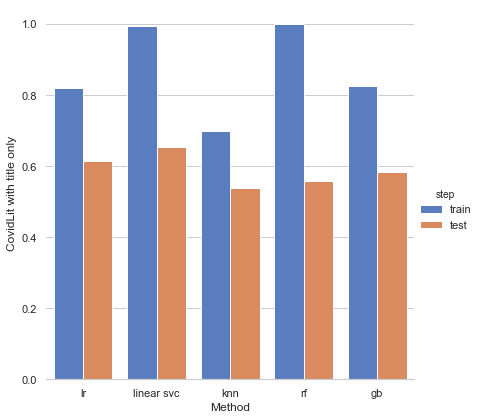

In [46]:
plot_data = pd.DataFrame(plot_data[1:], columns=plot_data[0])
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Method", y="score", hue="step", data=plot_data,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("CovidLit with title only")

### 1.2Using title text features with journal: 

In [128]:
plot_data=[["Method", "score", "step"]]
data.journal = data.journal.str.replace(' ', '')
X_train,X_test,y_train,y_test = train_test_split(data[['title','journal']], data.label,test_size=0.33,shuffle=True)

In [129]:
vect=CountVectorizer(ngram_range=(1,2))
X_train_title=vect.fit_transform(X_train.title)
ohe=OneHotEncoder(handle_unknown='ignore')#.fit(data.journal.values.reshape(-1, 1))
X_train_journal=ohe.fit_transform(X_train.journal.values.reshape(-1, 1))
X_train=hstack([X_train_title,X_train_journal]).toarray()
X_test_title=vect.transform(X_test.title)
X_test_journal=ohe.transform(X_test.journal.values.reshape(-1, 1))
X_test=hstack([X_test_title,X_test_journal]).toarray()

In [130]:
lr=LogisticRegression(max_iter=5000).fit(X_train,y_train)
print('logistic regression - val score:')
train_score=lr.score(X_train,y_train)
print(train_score)
plot_data.append(['logistic regression',train_score,'train'])
print('logistic regression - test score:')
test_score=lr.score(X_test,y_test)
print(test_score)
plot_data.append(['logistic regression',test_score,'test'])

logistic regression - val score:
0.997530186608123
logistic regression - test score:
0.6434540389972145


In [131]:
knn=KNeighborsClassifier().fit(X_train,y_train)
print('knn - val score:')
train_score=knn.score(X_train,y_train)
print(train_score)
plot_data.append(['knn',train_score,'train'])
print('knn - test score:')
test_score=knn.score(X_test,y_test)
print(test_score)
plot_data.append(['knn',test_score,'test'])

knn - val score:
0.5941273326015367
knn - test score:
0.37493036211699166


In [132]:
rf = RandomForestClassifier(warm_start=True)
rf.fit(X_train,y_train)
print('random forest - val score:')
train_score=rf.score(X_train,y_train)
print(train_score)
plot_data.append(['rf',train_score,'train'])
print('random forest - test score:')
test_score=rf.score(X_test,y_test)
print(test_score)
plot_data.append(['rf',test_score,'test'])

random forest - val score:
0.9991767288693744
random forest - test score:
0.5777158774373259


In [133]:
gb=GradientBoostingClassifier()
gb.fit(X_train,y_train)
print('GradientBoosting - val score:')
train_score=gb.score(X_train,y_train)
print(train_score)
plot_data.append(['GradientBoosting',train_score,'train'])
print('GradientBoosting - test score:')
test_score=gb.score(X_test,y_test)
print(test_score)
plot_data.append(['GradientBoosting',test_score,'test'])

GradientBoosting - val score:
0.7922612513721186
GradientBoosting - test score:
0.6211699164345403


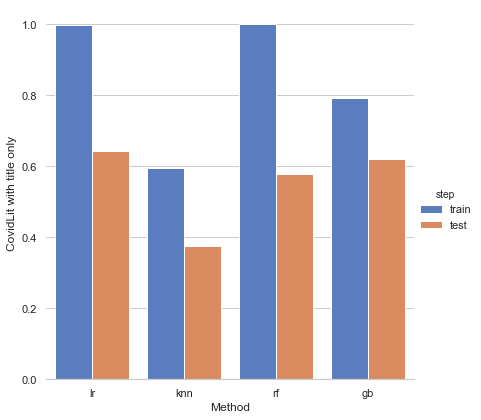

In [134]:
plot_data = pd.DataFrame(plot_data[1:], columns=plot_data[0])
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Method", y="score", hue="step", data=plot_data,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("CovidLit with title only")